<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1
!pip install tf-agents

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Error al cargar el fichero tablero, usando tablero aleatorio...
Error al cargar el fichero secuencia, usando secuencia aleatoria...
Que empiece el juego:😉


,0,1,2,3,4,5
A,a,b,.,b,.,a
B,.,a,b,c,.,.
C,.,b,a,a,.,.
D,.,.,c,a,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,.



Turno: 0 Puntos:105
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,.,c,.,.,a
B,.,a,.,c,.,.
C,.,b,a,a,.,.
D,.,.,c,a,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,.



Turno: 1 Puntos:115
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,.,c,.,.,a
B,.,.,b,c,.,.
C,.,b,.,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,.



Turno: 2 Puntos:116
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,.,c,.,.,a
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,.



Turno: 3 Puntos:131
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,a,c,.,.,a
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,.



Turno: 4 Puntos:132
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,a,c,.,a,a
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,.



Turno: 5 Puntos:133
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,a,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,.



Turno: 6 Puntos:136
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,c,b,.,.
B,b,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,.



Turno: 7 Puntos:139
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,.,c,b,.,.
B,b,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,2



Turno: 8 Puntos:134
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,b,.,c,b,.,.
B,b,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,a,.,a,.,a,2



Turno: 9 Puntos:139
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,b,.,c,b,.,.
B,b,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,a,.,.,.,.,a
F,a,.,a,.,a,2



Turno: 10 Puntos:140
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,b,.,c,b,.,.
B,b,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,.,b,.,.,a,2



Turno: 11 Puntos:142
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,.,a
F,.,b,.,.,a,2



Turno: 12 Puntos:157
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,b,.
F,.,b,.,.,.,2



Turno: 13 Puntos:160
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,b,a
F,.,b,.,.,.,2



Turno: 14 Puntos:161
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,b,a
F,.,b,.,.,a,2



Turno: 15 Puntos:162
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,.,b,a
F,.,b,.,a,a,2



Turno: 16 Puntos:163
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,b,b,a
F,.,b,.,.,.,2



Turno: 17 Puntos:166
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,b,b,a
F,.,b,.,.,a,2



Turno: 18 Puntos:167
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,b,b,a
F,.,b,.,a,a,2



Turno: 19 Puntos:168
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,b,b,a
F,.,b,b,.,.,2



Turno: 20 Puntos:171
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,b,b,a
F,.,b,b,.,1,2



Turno: 21 Puntos:146
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,b,b,a
F,.,b,b,a,2,2



Turno: 22 Puntos:167
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,c,c,b,.,.
B,.,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,b,b,a
F,.,b,b,a,2,2



Turno: 23 Puntos:168
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,c,c,b,.,.
B,a,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,b,b,a
F,.,b,b,a,2,2



Turno: 24 Puntos:169
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,a,c,c,b,1,.
B,a,.,.,c,.,.
C,.,.,c,.,.,.
D,.,.,c,.,.,c
E,.,.,.,b,b,a
F,.,b,b,a,2,2



Turno: 25 Puntos:144
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,c,c,b,.,1
B,a,.,.,c,.,.
C,.,.,.,.,.,.
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 26 Puntos:209
Almacen: [.] Actual: [c]


,0,1,2,3,4,5
A,a,.,.,b,.,.
B,a,d,.,c,.,1
C,.,.,.,.,.,.
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 27 Puntos:284
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,.,b,.,1
B,.,d,.,c,.,.
C,.,.,.,.,.,.
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 28 Puntos:287
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,.,b,.,.
B,.,d,.,c,a,1
C,.,.,.,.,.,.
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 29 Puntos:288
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,.,b,a,1
B,.,d,.,c,a,.
C,.,.,.,.,.,.
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 30 Puntos:289
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,b,.,b,a,1
B,.,d,.,c,a,1
C,.,.,.,.,.,.
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 31 Puntos:264
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,.,b,a,2
B,.,d,.,c,a,2
C,.,.,.,.,.,a
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 32 Puntos:305
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,.,b,.,2
B,.,d,.,c,.,2
C,.,.,.,.,b,.
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 33 Puntos:307
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,.,b,a,2
B,.,d,.,c,.,2
C,.,.,.,.,b,.
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 34 Puntos:308
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,.,c,.,a,2
B,.,d,.,c,.,2
C,.,.,.,.,b,.
D,.,.,.,d,.,c
E,.,.,.,.,.,a
F,.,b,b,a,2,2



Turno: 35 Puntos:323
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,.,c,.,a,2
B,.,d,.,c,.,2
C,.,.,.,.,b,.
D,.,.,.,d,.,c
E,.,c,.,.,.,a
F,.,.,.,a,2,2



Turno: 36 Puntos:338
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,c,a,a,2
B,.,d,.,c,.,2
C,.,.,.,.,b,.
D,.,.,.,d,.,c
E,.,c,.,.,.,a
F,.,.,.,a,2,2



Turno: 37 Puntos:339
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,.,c,a,a,3
B,.,d,.,c,.,.
C,.,.,.,.,b,.
D,.,.,.,d,.,c
E,.,c,.,.,.,a
F,.,.,.,a,2,2



Turno: 38 Puntos:399
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,.,c,a,a,3
B,.,d,.,c,.,.
C,.,.,.,.,b,.
D,.,.,.,d,.,c
E,.,c,.,.,1,a
F,.,.,.,a,2,2



Turno: 39 Puntos:374
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,1,.,c,a,a,3
B,.,d,.,c,.,.
C,.,.,.,.,b,.
D,.,.,.,d,1,c
E,.,c,.,.,.,a
F,.,.,.,a,2,2



Turno: 40 Puntos:349
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,1,c,a,a,3
B,.,d,.,c,.,.
C,.,.,.,.,b,.
D,.,.,.,d,2,c
E,.,c,.,.,a,a
F,.,.,.,a,2,2



Turno: 41 Puntos:370
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,1,1,c,a,a,3
B,.,d,.,c,.,.
C,.,.,.,.,b,.
D,.,.,.,d,2,c
E,.,c,.,.,a,a
F,.,.,.,a,2,2



Turno: 42 Puntos:345
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,a,a,3
B,a,d,.,c,.,.
C,.,.,.,.,b,.
D,.,.,.,d,2,c
E,.,c,.,.,a,a
F,.,.,.,a,2,2



Turno: 43 Puntos:386
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,c,b,.
C,.,.,.,.,b,.
D,.,.,.,d,2,c
E,.,c,.,.,a,a
F,.,.,.,a,2,2



Turno: 44 Puntos:389
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,c,b,.
C,.,.,.,.,b,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 45 Puntos:391
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,c,b,.
C,a,.,.,.,b,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 46 Puntos:392
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,.,d,.,c,b,.
C,.,b,.,.,b,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 47 Puntos:395
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,c,b,.
C,.,b,.,.,b,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 48 Puntos:396
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,c,b,.
C,a,b,.,.,b,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 49 Puntos:397
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,c,.,.
C,a,b,.,c,.,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 50 Puntos:412
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,c,.,.
C,a,b,.,c,a,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 51 Puntos:413
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,c,a,.
C,a,b,.,c,a,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 52 Puntos:414
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,b,3
B,a,d,.,c,.,.
C,a,b,.,c,.,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 53 Puntos:417
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,b,3
B,a,d,.,c,.,.
C,a,b,.,c,a,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 54 Puntos:418
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,b,3
B,a,d,.,c,a,.
C,a,b,.,c,a,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 55 Puntos:419
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,b,3
B,a,d,.,c,.,b
C,a,b,.,c,.,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 56 Puntos:422
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,.,d,.
C,a,b,.,.,.,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 57 Puntos:487
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,.,d,.
C,a,b,.,.,a,.
D,.,.,.,d,2,c
E,.,c,.,b,.,.
F,.,.,.,.,2,2



Turno: 58 Puntos:488
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,.,d,.
C,a,b,.,.,a,.
D,.,.,.,d,2,c
E,.,c,.,b,1,.
F,.,.,.,.,2,2



Turno: 59 Puntos:463
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,.,d,.
C,a,b,.,.,a,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 60 Puntos:554
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,.,3
B,a,d,.,.,d,.
C,a,b,.,a,a,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 61 Puntos:555
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,2,c,1,.,3
B,a,d,.,.,d,.
C,a,b,.,a,a,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 62 Puntos:530
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,.,1,3
B,a,d,.,.,d,.
C,a,b,b,.,.,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 63 Puntos:533
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,2,c,1,1,3
B,a,d,.,.,d,.
C,a,b,b,.,.,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 64 Puntos:508
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,a,d,.,a,d,.
C,a,b,b,.,.,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 65 Puntos:549
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,a,d,2,a,d,.
C,a,b,b,.,.,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 66 Puntos:544
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,a,d,2,a,d,.
C,a,b,b,a,.,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 67 Puntos:545
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,a,d,2,a,d,1
C,a,b,b,a,.,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 68 Puntos:520
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,a,d,2,a,d,2
C,a,b,b,a,.,a
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 69 Puntos:541
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,a,d,2,.,d,2
C,a,b,b,.,b,.
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 70 Puntos:543
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,a,d,2,.,d,2
C,a,b,b,.,b,2
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 71 Puntos:538
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,a,d,2,a,d,2
C,a,b,b,.,b,2
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 72 Puntos:539
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,a,d,2,a,d,2
C,a,b,b,a,b,2
D,.,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 73 Puntos:540
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,.,d,2,a,d,2
C,.,b,b,a,b,2
D,b,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 74 Puntos:543
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,2,c,2,2,3
B,1,d,2,a,d,2
C,.,b,b,a,b,2
D,b,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 75 Puntos:518
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,2,3
B,.,d,2,a,d,2
C,a,b,b,a,b,2
D,b,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 76 Puntos:604
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,2,3
B,a,d,2,a,d,2
C,a,b,b,a,b,2
D,b,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 77 Puntos:605
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,b,3,c,2,2,3
B,.,d,2,a,d,2
C,.,b,b,a,b,2
D,b,.,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 78 Puntos:608
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,b,3,c,2,2,3
B,.,d,2,a,d,2
C,.,.,.,a,b,2
D,.,c,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 79 Puntos:618
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,b,3,c,2,2,3
B,.,d,2,.,d,2
C,.,.,b,.,b,2
D,.,c,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 80 Puntos:621
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,b,3,c,2,2,3
B,.,d,2,1,d,2
C,.,.,b,.,b,2
D,.,c,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 81 Puntos:596
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,b,3,c,.,3,3
B,.,d,.,.,d,2
C,.,.,b,a,b,2
D,.,c,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 82 Puntos:687
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,b,3,c,.,3,3
B,b,d,.,.,d,2
C,.,.,b,a,b,2
D,.,c,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 83 Puntos:692
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,b,3,c,1,3,3
B,b,d,.,.,d,2
C,.,.,b,a,b,2
D,.,c,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 84 Puntos:667
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,b,3,c,2,3,3
B,b,d,.,a,d,2
C,.,.,b,a,b,2
D,.,c,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 85 Puntos:688
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,b,3,c,2,3,3
B,b,d,b,.,d,2
C,.,.,b,.,b,2
D,.,c,.,d,.,c
E,.,c,.,b,.,a
F,.,.,.,.,.,3



Turno: 86 Puntos:691
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,b,3,c,2,3,3
B,b,d,.,.,d,2
C,.,d,.,.,b,2
D,.,.,.,d,.,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 87 Puntos:756
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,.,.,d,2
C,c,d,.,.,b,2
D,.,.,.,d,.,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 88 Puntos:771
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,.,a,d,2
C,c,d,.,.,b,2
D,.,.,.,d,.,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 89 Puntos:772
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,a,a,d,2
C,c,d,.,.,b,2
D,.,.,.,d,.,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 90 Puntos:773
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,.,.,d,2
C,c,d,.,b,b,2
D,.,.,.,d,.,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 91 Puntos:776
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,.,a,d,2
C,c,d,.,b,b,2
D,.,.,.,d,.,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 92 Puntos:777
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,a,a,d,2
C,c,d,.,b,b,2
D,.,.,.,d,.,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 93 Puntos:778
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,a,a,d,2
C,c,d,.,.,.,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 94 Puntos:793
Almacen: [.] Actual: [w]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,a,a,d,.
C,c,d,.,.,.,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 95 Puntos:798
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,a,a,d,a
C,c,d,.,.,.,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 96 Puntos:799
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,.,.,d,a
C,c,d,b,.,.,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 97 Puntos:802
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,.,a,d,a
C,c,d,b,.,.,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 98 Puntos:803
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,.,.,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 99 Puntos:798
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,.,1,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 100 Puntos:773
Almacen: [.] Actual: [w]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,.,.,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 101 Puntos:798
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,a,.,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 102 Puntos:799
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,a,2,2
D,.,.,.,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 103 Puntos:794
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,a,2,2
D,.,.,b,d,c,c
E,.,.,.,b,.,a
F,.,.,.,.,.,3



Turno: 104 Puntos:799
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,a,2,2
D,.,.,b,d,c,c
E,.,.,.,b,a,a
F,.,.,.,.,.,3



Turno: 105 Puntos:800
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,.,a,2,2
D,.,c,.,d,c,c
E,.,.,.,b,a,a
F,.,.,.,.,.,3



Turno: 106 Puntos:815
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,.,d,a
C,c,d,b,.,2,2
D,.,c,.,d,c,c
E,.,.,.,b,a,a
F,.,.,.,.,.,3



Turno: 107 Puntos:818
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,.,2,2
D,.,c,.,d,c,c
E,.,.,.,b,a,a
F,.,.,.,.,.,3



Turno: 108 Puntos:819
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,.,d,c,c
E,.,.,.,b,a,a
F,.,.,.,.,.,3



Turno: 109 Puntos:820
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,.,d,c,c
E,.,.,.,b,.,.
F,.,.,.,.,b,3



Turno: 110 Puntos:823
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,.,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,.,d,c,c
E,.,.,.,b,.,.
F,.,.,.,.,b,3



Turno: 111 Puntos:824
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,.,d,c,c
E,.,.,.,b,.,.
F,.,.,.,.,b,3



Turno: 112 Puntos:825
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,a,c,.,d,c,c
E,.,.,.,b,.,.
F,.,.,.,.,b,3



Turno: 113 Puntos:826
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,a,c,.,d,c,c
E,a,.,.,b,.,.
F,.,.,.,.,b,3



Turno: 114 Puntos:827
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,a,c,1,d,c,c
E,a,.,.,b,.,.
F,.,.,.,.,b,3



Turno: 115 Puntos:802
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,a,c,2,d,c,c
E,a,.,a,b,.,.
F,.,.,.,.,b,3



Turno: 116 Puntos:823
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,2,d,c,c
E,.,b,.,b,.,.
F,.,.,.,.,b,3



Turno: 117 Puntos:825
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,2,d,c,c
E,.,b,1,b,.,.
F,.,.,.,.,b,3



Turno: 118 Puntos:800
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,2,d,.,.
E,.,b,.,1,d,.
F,.,.,.,.,.,3



Turno: 119 Puntos:865
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,2,d,a,.
E,.,b,.,.,d,.
F,.,.,.,1,.,3



Turno: 120 Puntos:866
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,2,d,a,a
E,.,b,.,1,d,.
F,.,.,.,.,.,3



Turno: 121 Puntos:867
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,2,d,a,a
E,.,b,a,.,d,.
F,.,.,.,1,.,3



Turno: 122 Puntos:868
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,c,d,b,a,2,2
D,.,c,2,d,a,a
E,b,b,a,1,d,.
F,.,.,.,.,.,3



Turno: 123 Puntos:873
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,3,c,2,3,3
B,a,d,2,a,d,a
C,.,d,b,a,2,2
D,d,.,2,d,a,a
E,.,.,a,.,d,.
F,.,.,.,1,.,3



Turno: 124 Puntos:938
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,b,d,b,a,2,2
D,d,.,2,d,a,a
E,.,.,a,1,d,.
F,.,.,.,.,.,3



Turno: 125 Puntos:941
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,b,d,b,a,2,2
D,d,.,2,d,a,a
E,.,.,a,2,d,.
F,.,.,.,a,.,3



Turno: 126 Puntos:962
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,2,d,a,a
E,.,.,a,2,d,.
F,.,.,.,a,.,3



Turno: 127 Puntos:963
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,b,d,b,a,2,2
D,d,.,2,d,a,a
E,.,b,.,2,d,.
F,.,.,.,a,.,3



Turno: 128 Puntos:966
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,2,d,a,a
E,.,b,.,2,d,.
F,.,.,.,a,.,3



Turno: 129 Puntos:967
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,.,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,2,d,a,a
E,.,b,.,2,d,2
F,.,.,.,a,.,3



Turno: 130 Puntos:962
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,2,d,a,a
E,.,b,.,2,d,2
F,.,.,.,a,.,3



Turno: 131 Puntos:967
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,2,d,a,a
E,.,b,a,2,d,2
F,.,.,.,a,.,3



Turno: 132 Puntos:968
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,2,d,a,a
E,.,b,.,2,d,2
F,.,.,b,.,.,3



Turno: 133 Puntos:971
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,3,d,a,a
E,.,b,.,.,d,2
F,.,.,b,.,.,3



Turno: 134 Puntos:1031
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,3,d,a,a
E,.,b,.,.,d,2
F,.,.,b,.,.,3



Turno: 135 Puntos:1026
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,3,d,a,a
E,a,b,.,.,d,2
F,.,.,b,.,.,3



Turno: 136 Puntos:1027
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,3,d,a,a
E,a,b,.,.,d,2
F,a,.,b,.,.,3



Turno: 137 Puntos:1028
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,3,d,a,a
E,.,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 138 Puntos:1041
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,3,d,a,a
E,.,a,.,.,d,2
F,.,c,.,.,.,3



Turno: 139 Puntos:1042
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,.,3,d,a,a
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 140 Puntos:1045
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,2,2
D,d,a,3,d,a,a
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 141 Puntos:1046
Almacen: [.] Actual: [w]


,0,1,2,3,4,5
A,2,3,c,2,3,3
B,b,d,2,a,d,a
C,b,d,b,a,.,2
D,d,a,3,d,a,a
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 142 Puntos:1051
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,2,3,3
B,b,d,2,.,d,a
C,b,d,b,.,b,2
D,d,a,3,d,.,.
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 143 Puntos:1052
Almacen: [.] Actual: [w]


,0,1,2,3,4,5
A,2,3,c,.,3,3
B,b,d,2,.,d,a
C,b,d,b,.,b,2
D,d,a,3,d,.,.
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 144 Puntos:1057
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,.,3,3
B,b,d,2,a,d,a
C,b,d,b,.,b,2
D,d,a,3,d,.,.
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 145 Puntos:1058
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,.,b,2
D,d,a,3,d,.,.
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 146 Puntos:1059
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,a,3,d,.,.
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 147 Puntos:1054
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,a,3,d,.,a
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 148 Puntos:1055
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,a,3,d,a,a
E,b,.,.,.,d,2
F,.,c,.,.,.,3



Turno: 149 Puntos:1056
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,a,3,d,a,a
E,b,a,.,.,d,2
F,.,c,.,.,.,3



Turno: 150 Puntos:1057
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,a,3,d,a,a
E,b,a,.,.,d,2
F,b,c,.,.,.,3



Turno: 151 Puntos:1062
Almacen: [.] Actual: [c]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,a,3,d,a,a
E,b,a,.,.,d,2
F,b,c,c,.,.,3



Turno: 152 Puntos:1087
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,.,3,d,a,a
E,b,.,b,.,d,2
F,b,c,c,.,.,3



Turno: 153 Puntos:1090
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,1,3,d,a,a
E,b,.,b,.,d,2
F,b,c,c,.,.,3



Turno: 154 Puntos:1065
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,2,3,d,a,a
E,b,a,b,.,d,2
F,b,c,c,.,.,3



Turno: 155 Puntos:1086
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,2,3,d,a,a
E,b,a,b,a,d,2
F,b,c,c,.,.,3



Turno: 156 Puntos:1087
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,2,3,d,a,a
E,b,a,b,a,d,2
F,b,c,c,1,.,3



Turno: 157 Puntos:1062
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,3,c,a,3,3
B,b,d,2,a,d,a
C,b,d,b,2,b,2
D,d,2,3,d,a,a
E,b,a,b,a,d,2
F,b,c,c,2,a,3



Turno: 158 Puntos:1083
Almacen: [.] Actual: [a]
Partida terminada, GG:👏


<ipython-input-94-1bd7a7e8011d>:150: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]


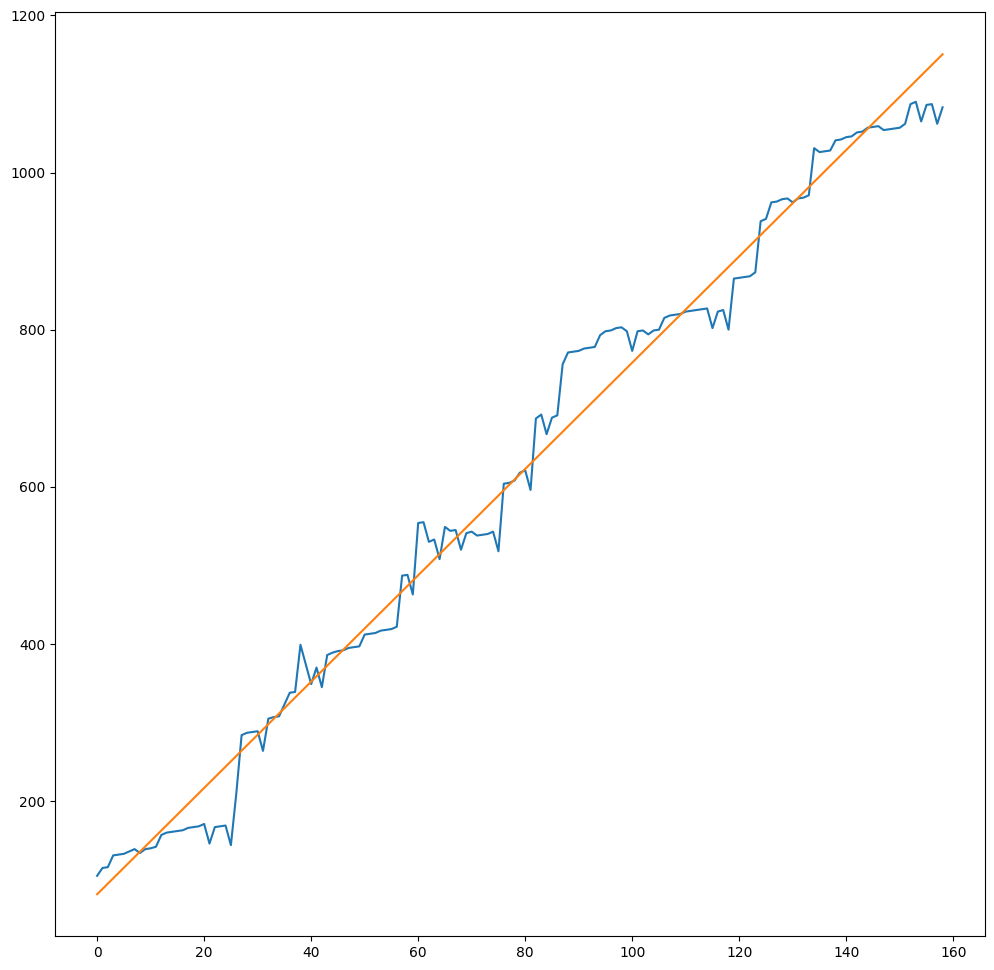

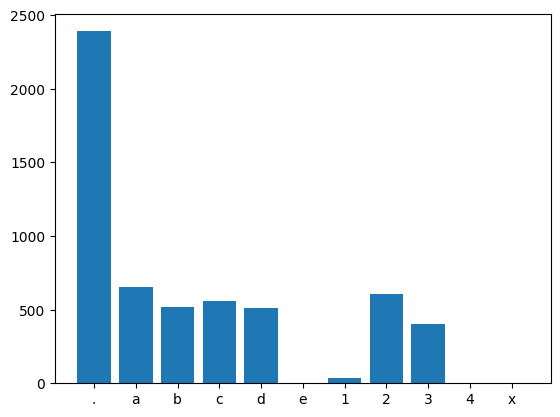

In [94]:
import random
import math
import copy
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    #random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles(1)    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[(i,j), 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]
    self.updateActual()
    self.appearances = {i:0 for i in self.objects.keys()}
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self, verbose=0):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 6) for i in range(6)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio..."*verbose)      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria..."*verbose)      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada("hint") #self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.updateActual(); self.showGame(); continue;
      coordinates = (lambda l: (int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])))(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
      for i in self.matrix:
          for j in i:
              self.appearances[j]+=1
    print("Partida terminada, GG:\U0001F44F")
    self.plotScore()
    plt.bar(list(self.appearances.keys()), list(self.appearances.values()))

  def getHint(self):
    prevObjs = sum(4 - self.objects[b][1] for a in self.matrix for b in a if b!=".")
    tempValues=[-math.inf, (0,0)]
    #debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): 
          newObj = copy.deepcopy(g)
          newObj.updateMatrix((i,j))
          newScore = sum(sum(self.objects[b][1] - 4*(b != "." or 0) for b in a) for a in newObj.matrix) + prevObjs - 10*newObj.minDistanceToElement((i,j), ["1", "2", newObj.matrix[i][j]])
          if newScore>tempValues[0]: tempValues = [newScore, (i,j)]
          #debugValues[i][j] = newScore
    #plt.imshow(debugValues, cmap='hot', interpolation='nearest')
    #plt.show()
    return tempValues[1]
  
  def plotScore(self, size=12):
    x = np.array(list(range(len(self.score))))
    m,c = self.linReg(x, self.score)
    fig = plt.figure(figsize=(size, size))
    plt.plot(x, self.score)
    plt.plot(x, m*x + c)
    plt.show()
  
  def linReg(self, x, y):
    return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]

  def minDistanceToElement(self, coordinates, elements):
    visited = set()
    q = [(coordinates, 0)]
    while q:
        n, distance = q.pop(0)
        if n in visited:
            continue
        visited.add(n)
        for i, j in ((n[0]-1, n[1]), (n[0]+1, n[1]), (n[0], n[1]-1), (n[0], n[1]+1)):
            if i < 0 or i >= len(self.matrix) or j < 0 or j >= len(self.matrix[0]): continue
            if self.matrix[i][j] in elements: return distance+1
            q.append(((i,j), distance+1))
    return 0   
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*6+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(((n[0][0]-1, n[0][1]), (n[0][0], n[0][1]+1), (n[0][0]+1, n[0][1]), (n[0][0], n[0][1]-1))):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    visited = set()
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      visited.add(n)
      for i in ((n[0]-1, n[1]), (n[0], n[1]+1), (n[0]+1, n[1]), (n[0], n[1]-1)):
        if i[0] < 0 or i[0] >= len(self.matrix) or i[1] < 0 or i[1] >= len(self.matrix[0]): continue
        if (not i in visited) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":
  g = MainGame()
  g.main()  

**Bot Encoding**

In [ ]:
import gym
import tensorflow as tf
import tf_agents

In [ ]:
class GameEnv(gym.Env, MainGame):
    def __init__(self, goal_velocity=0):
        self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
        self.storage="."
        self.verbose = False
        self.viewer = None

        self.action_space = gym.spaces.Box(
            low=0,
            high=36,
            shape=(36,),
            dtype=np.float32
        )
        self.observation_space = gym.spaces.Box(
            low=0,
            high=123,
            shape=(37,),
            dtype=np.float32
        )

        self.score = []
        self.seed()
        self.reset()

        self.state_log = []

    def seed(self, seed=None):
        random.seed()
        gym.utils.seeding.np_random()
    
    def getState(self):
        return np.array([ord(i) for i in np.array(self.matrix).reshape(36).tolist()]+[ord(self.actual)])

    def step(self, action):
        for i in range(len(self.matrix)):
          for j in range(len(self.matrix[0])):
            action[6*i+j]*=((self.matrix[i][j]==".") ^ (self.actual=="w"))
        action = action.argmax()
        self.last_action = action
        coordinates = (action//6 if action!=36 else 5, action%6)
        # perform move and get new state
        try:
            reward = sum(self.objects[j][1] for i in self.matrix for j in i)
            self.updateMatrix(coordinates)
            self.updateActual()
            self.turn+=1
            self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
            self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
            reward = self.score[-1]-reward+self.linReg(np.array(list(range(len(self.score)))), self.score)[0]*len(self.score)        
            done = not (any("." in x for x in self.matrix))
        except:
            reward = -50
            done = True            
        return self.getState(), reward, done, {}

    def reset(self):
        if random.randint(0, 200)%3 == 0: self.plotScore(4)
        self.seed()
        self.checkAndLoadFiles()
        self.turn = 0
        self.score = []
        self.bigFoots = [[(i,j), 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]
        self.updateActual()
        return self.getState()

    def close(self):
        pass

env_name = 'main-env'
gym.envs.registration.register(id=env_name,entry_point=f'{__name__}:GameEnv')
env = gym.make(env_name)

In [ ]:
env = tf_agents.environments.suite_gym.load(env_name)
env.reset()
#env.showGame()

train_py_env = tf_agents.environments.suite_gym.load(env_name)
eval_py_env = tf_agents.environments.suite_gym.load(env_name)

train_env = tf_agents.environments.tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_agents.environments.tf_py_environment.TFPyEnvironment(eval_py_env)

def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

actor_fc_layers = (400, 300)
critic_obs_fc_layers = (400,)
critic_action_fc_layers = None
critic_joint_fc_layers = (300,)
ou_stddev = 0.2
ou_damping = 0.15
target_update_tau = 0.05
target_update_period = 5
dqda_clipping = None
td_errors_loss_fn = tf.compat.v1.losses.huber_loss
gamma = 0.995
reward_scale_factor = 1.0
gradient_clipping = None

actor_learning_rate = 0.0001
critic_learning_rate = 0.001
debug_summaries = False
summarize_grads_and_vars = False

global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = tf_agents.agents.ddpg.actor_network.ActorNetwork(
    train_env.time_step_spec().observation,
    train_env.action_spec(),
    fc_layer_params=actor_fc_layers,
)

critic_net_input_specs = (train_env.time_step_spec().observation,
                          train_env.action_spec())

critic_net = tf_agents.agents.ddpg.critic_network.CriticNetwork(
    critic_net_input_specs,
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers,
)

tf_agent = tf_agents.agents.ddpg.ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()

step = 10: loss = 139.53651428222656


step = 20: loss = 143.7396240234375


step = 30: loss = 225.6874542236328
step = 40: loss = 175.13568115234375
step = 50: loss = 151.46051025390625


step = 60: loss = 135.88650512695312
step = 70: loss = 95.07243347167969


step = 80: loss = 91.81466674804688


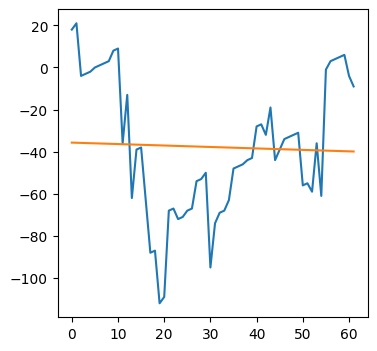



step = 90: loss = 97.9754638671875


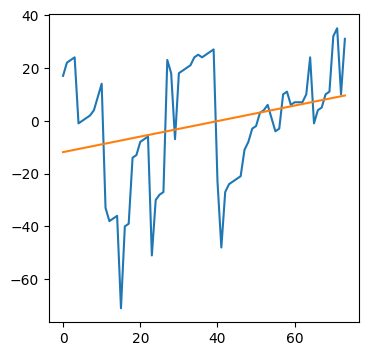



step = 100: loss = 80.40753173828125
step = 110: loss = 69.70610046386719


step = 120: loss = 95.42972564697266


step = 130: loss = 86.87492370605469
step = 140: loss = 78.12567138671875


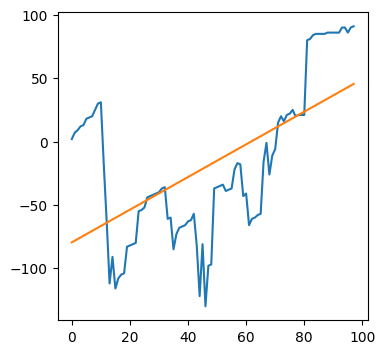



step = 150: loss = 85.2077865600586


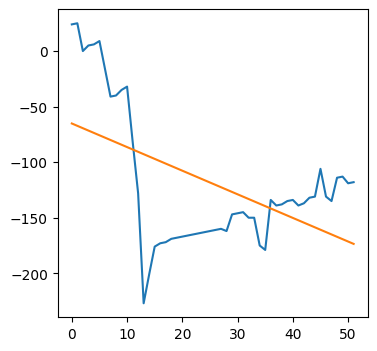

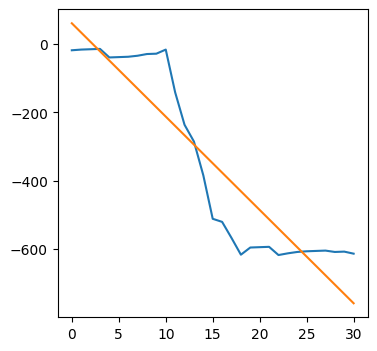



step = 160: loss = 94.77539825439453


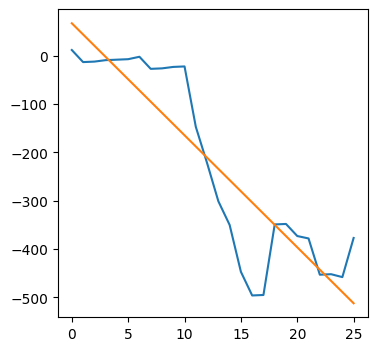



step = 170: loss = 84.87036895751953


step = 180: loss = 88.87613677978516


step = 190: loss = 83.42727661132812


step = 200: loss = 79.6612319946289


step = 210: loss = 94.68536376953125


step = 220: loss = 100.39371490478516


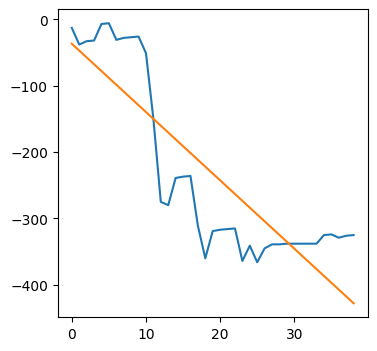

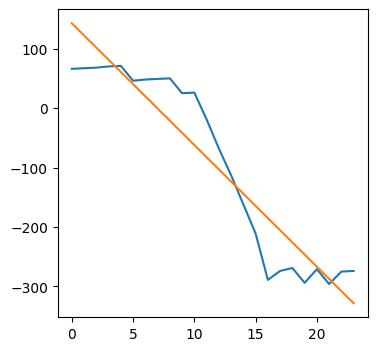



step = 230: loss = 118.36621856689453


step = 240: loss = 91.60052490234375
step = 250: loss = 101.15414428710938


step = 260: loss = 88.29594421386719


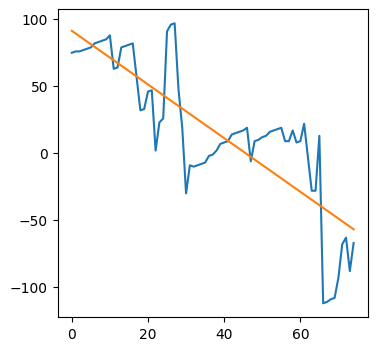



step = 270: loss = 83.2823486328125


step = 280: loss = 85.82962799072266
step = 290: loss = 89.9625015258789


step = 300: loss = 105.55145263671875


step = 310: loss = 105.0050277709961


step = 320: loss = 97.8819351196289


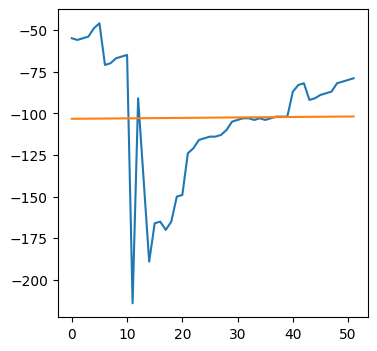



step = 330: loss = 89.73094940185547
step = 340: loss = 80.88241577148438


step = 350: loss = 103.9177474975586


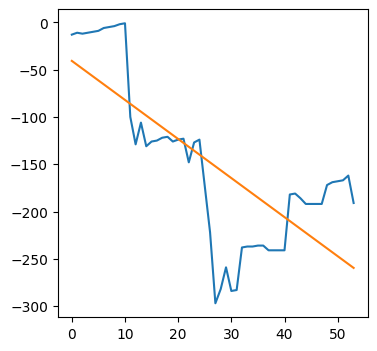



step = 360: loss = 98.288330078125
step = 370: loss = 133.77816772460938


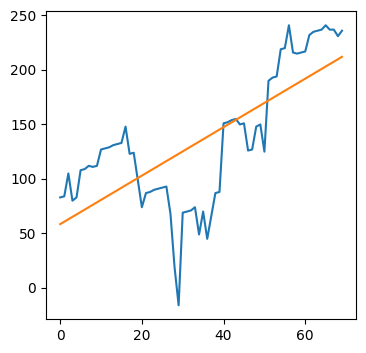



step = 380: loss = 97.92461395263672




step = 390: loss = 127.41010284423828
step = 400: loss = 116.15725708007812


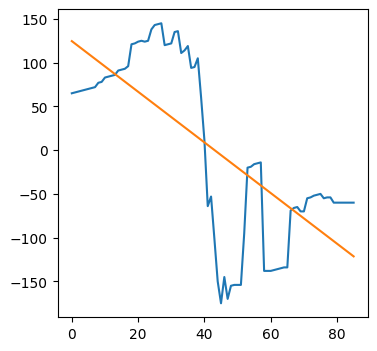



step = 410: loss = 127.95974731445312


step = 420: loss = 135.87973022460938


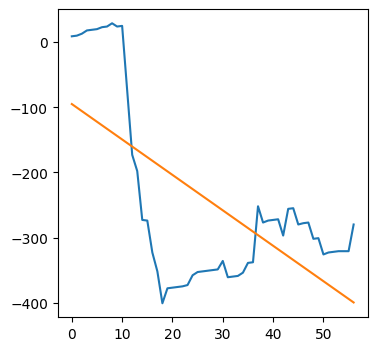



step = 430: loss = 109.54644012451172


step = 440: loss = 122.43541717529297
step = 450: loss = 136.55091857910156


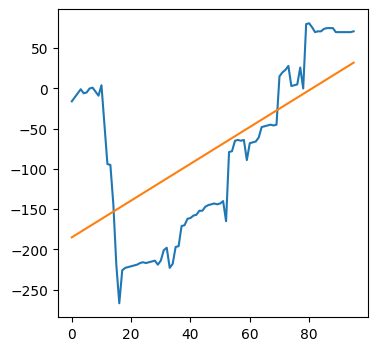



step = 460: loss = 108.91053009033203
step = 470: loss = 99.83287811279297


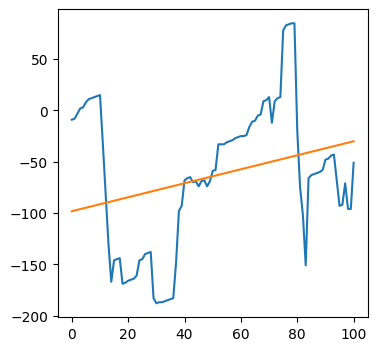



step = 480: loss = 147.9833526611328
step = 490: loss = 114.34860229492188


step = 500: loss = 103.75892639160156


In [ ]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = tf_agents.trajectories.trajectory.from_transition(time_step, action_step,next_time_step)
    # Add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


random_policy = tf_agents.policies.random_tf_policy.RandomTFPolicy(\
    train_env.time_step_spec(),\
    train_env.action_spec())

replay_buffer = tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=100,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using
# TF function.
tf_agent.train = tf_agents.utils.common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, 3)
returns = [avg_return]

for _ in range(500):
    for _ in range(5):
        collect_step(train_env, tf_agent.collect_policy, replay_buffer)

    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience).loss

    step = tf_agent.train_step_counter.numpy()

    if step % 10 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    #if step % 2 == 0:
    #    avg_return = compute_avg_return(eval_env, tf_agent.policy,3)
    #    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    #    returns.append(avg_return)

**Pytorch Version**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import random
import numpy as np
from collections import deque

BATCH_SIZE = 50

class QNet(nn.Module):
    def __init__(self, input_size=37, hidden_size=62, output_size=36):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        x = F.leaky_relu(self.linear4(x))
        x = F.leaky_relu(self.linear5(x))
        x = F.softmax(self.linear6(x))
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)
        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)
        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))
            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()

class Agent:
    def __init__(self):
        self.nGames = 0        
        self.memory = deque(maxlen=100000)
        self.model = QNet()
        self.trainer = QTrainer(self.model, lr=0.0012, gamma=0.9)

    def get_state(self, game):        
        return np.array([ord(i) for i in np.array(game.matrix).reshape(36).tolist()]+[ord(game.actual)])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory
        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state, matrix, actual):
        prediction = self.model(torch.tensor(state, dtype=torch.float))
        for i in range(len(matrix)):
          for j in range(len(matrix[0])):
            prediction[6*i+j]*=((matrix[i][j]==".") ^ (actual=="w"))
        
        final_move = torch.argmax(prediction).item()
        final_move = [final_move//6 if final_move!=36 else 5, final_move%6] 
        return final_move

def train():
    total_score = 0
    record = 0
    agent = Agent()
    game = MainGame()
    while True:
        state_old = agent.get_state(game)
        coordinates = tuple(agent.get_action(state_old, game.matrix, game.actual))
        # perform move and get new state
        reward = sum(game.objects[j][1] for i in game.matrix for j in i)
        game.updateMatrix(coordinates)
        game.updateActual()
        game.turn+=1
        game.bigFoots = [[i[0], i[1]+1, i[2]] for i in game.bigFoots]
        game.score.append(sum(game.objects[j][1] for i in game.matrix for j in i))
        reward = game.score[-1]-reward+game.linReg(np.array(list(range(len(game.score)))), game.score)[0]*len(game.score)        
        done = not (any("." in x for x in game.matrix))
        state_new = agent.get_state(game)

        agent.train_short_memory(state_old, coordinates, reward, state_new, done)
        agent.remember(state_old, coordinates, reward, state_new, done)

        if done:
            if agent.nGames%4 == 0:
              game.showGame()
              game.plotScore()  
            # train long memory, plot result, RESET GAME
            random.seed()
            game.checkAndLoadFiles()
            game.turn = 0
            game.score = []
            game.bigFoots = [[(i,j), 0, False] for i in range(len(game.matrix)) for j in range(len(game.matrix[0])) if game.matrix[i][j]=="1"]
            game.updateActual()
            
            agent.nGames += 1
            agent.train_long_memory()
            agent.model.save()

            print('Game', agent.nGames, 'Record:', record)

if __name__ == '__main__':
    train()